# Project 3
## Group 22
### Topic: EEG Classification Model

# Data Preprocessing & Feature Extraction

In [2]:
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import glob
import os.path
import numpy as np
import os
import pyedflib
import numpy as np
import tqdm
import mne
from scipy.signal import welch, stft
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import euclidean

In [3]:
def extract_basic_features(signal):
    # Normalize the signal
    signal = (signal - np.mean(signal)) / np.std(signal)
    mean = np.mean(signal)
    std = np.std(signal)
    sample_entropy = np.log(np.std(np.diff(signal)))
    fuzzy_entropy = -np.log(euclidean(signal[:-1], signal[1:]) / len(signal))
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return [mean, std, sample_entropy, fuzzy_entropy, skewness, kurt]

def extract_advanced_features(data, fs, window_length_sec=3):
    # Extract advanced features using Short-Time Fourier Transform (STFT) from EEG data.
    # Perform STFT
    f, t, Zxx = stft(data, fs, nperseg=window_length_sec*fs)    
    # Extract features from STFT
    power = np.mean(np.abs(Zxx)**2, axis=1)
    return power

def preprocess_and_extract_features_mne_with_timestamps(file_name):
    # Preprocess EEG data using the mne library and extract basic and advanced features.
    # Load data
    raw = mne.io.read_raw_edf(file_name, preload=True)
    # Apply bandpass filter
    raw.filter(1., 50., fir_design='firwin')
    # Select EEG channels
    raw.pick_types(meg=False, eeg=True, eog=False)
    # Define parameters for short time window
    window_length = 3
    sfreq = raw.info['sfreq']
    window_samples = int(window_length * sfreq)
    features_with_timestamps = []
    for start in range(0, len(raw.times), window_samples):
        end = start + window_samples
        if end > len(raw.times):
            break
        # Extract and preprocess data in this window
        window_data, times = raw[:, start:end]
        window_data = np.squeeze(window_data)
        # Get the starting timestamp of the window
        timestamp = raw.times[start]
        # Extract basic and advanced features for each channel in each window
        for channel_data in window_data:
            basic_features = extract_basic_features(channel_data)
            advanced_features = extract_advanced_features(channel_data, sfreq)
            combined_features = np.concatenate([[timestamp], basic_features, advanced_features])
            features_with_timestamps.append(combined_features)

    return np.array(features_with_timestamps)

def extractTarget(summary_file_path, edf_file_path):
    edf_file_name = os.path.basename(edf_file_path)
    seizure_start_time = None
    seizure_end_time = None
    # Open and read the text file
    with open(summary_file_path, 'r') as file:
        lines = file.readlines()
    found = False
    # Iterate through each line in the file
    for line in lines:
        if "File Name: " + edf_file_name in line:
            found = True
        if found:
            if "Number of Seizures in File: 0" in line:
                return None, None  # No seizures, directly return None
            if "Seizure Start Time:" in line:
                seizure_start_time = int(line.split(": ")[1].split(" ")[0])
            elif "Seizure 1 Start Time:" in line:
                seizure_start_time = int(line.split(": ")[1].split(" ")[0])
            if "Seizure End Time:" in line:
                seizure_end_time = int(line.split(": ")[1].split(" ")[0])
                break 
            elif "Seizure 1 End Time:" in line:
                seizure_end_time = int(line.split(": ")[1].split(" ")[0])
                break 
    return seizure_start_time, seizure_end_time

def extract_data_and_labels(edf_file_path, summary_file_path):
    # Extract features
    X = preprocess_and_extract_features_mne_with_timestamps(edf_file_path)    
    # Extract labels
    seizure_start_time, seizure_end_time = extractTarget(summary_file_path, edf_file_path)
    if seizure_start_time is None or seizure_end_time is None:
        return None, None

    y = np.array([1 if seizure_start_time <= row[0] <= seizure_end_time else 0 for row in X])
    # Remove the first column 'Time' from the X array
    X = X[:, 1:]
    return X, y

base_path = "/Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3"
all_X = []
all_y = []

for subject_id in range(1,6):
 
    # Load data
    edf_file_paths = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file_path = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))
    X_val = []
    y_val = []

    for edf_file_path in edf_file_paths:
        X, y = extract_data_and_labels(edf_file_path, summary_file_path)
        if X is not None and y is not None:
            X_val.append(X)
            y_val.append(y)
    #if not X_val:
        #continue 
    
    print("###########Extracted values\n")
    print("X value\n")
    print(X_val)
    print("y value\n")
    print(y_val)
    
    max_columns = max(x.shape[1] for x in X_val)
    X_val = [np.pad(x, ((0, 0), (0, max_columns - x.shape[1])), mode='constant', constant_values=0) for x in X_val]
    subject_X, subject_y = X_val, y_val
    
    
    if subject_X is not None and subject_y is not None:
        all_X.extend(subject_X)
        all_y.extend(subject_y)

max_columns = max(x.shape[1] for x in all_X)
all_X = [np.pad(x, ((0, 0), (0, max_columns - x.shape[1])), mode='constant', constant_values=0) for x in all_X]

X = np.vstack(all_X)
y = np.concatenate(all_y)


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb01/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb01/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


###########Extracted values

X value

[array([[ 2.77555756e-17,  1.00000000e+00, -1.56988454e+00, ...,
         2.08211612e-16,  2.08014730e-16,  2.07823808e-16],
       [ 0.00000000e+00,  1.00000000e+00, -1.96438232e+00, ...,
         1.57093798e-15,  1.57081930e-15,  1.57076490e-15],
       [-9.25185854e-18,  1.00000000e+00, -2.13610203e+00, ...,
         9.86937036e-17,  9.87382921e-17,  9.87860817e-17],
       ...,
       [-1.85037171e-17,  1.00000000e+00, -7.37265485e-01, ...,
         9.03935269e-16,  9.05453886e-16,  9.07311722e-16],
       [ 1.38777878e-17,  1.00000000e+00, -1.42045819e+00, ...,
         2.79943262e-16,  2.80247265e-16,  2.80599784e-16],
       [ 0.00000000e+00,  1.00000000e+00, -2.05467363e+00, ...,
         1.53083351e-16,  1.52989510e-16,  1.52917476e-16]]), array([[ 3.70074342e-17,  1.00000000e+00, -1.47049247e+00, ...,
         2.10500138e-15,  2.10481743e-15,  2.10499925e-15],
       [ 3.70074342e-17,  1.00000000e+00, -1.61983473e+00, ...,
         4.7796

/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb02/chb02_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245503  =      0.000 ...   958.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb02/chb02_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


###########Extracted values

X value

[array([[ 1.85037171e-17,  1.00000000e+00, -2.04383494e+00, ...,
         5.00877178e-15,  5.00134365e-15,  4.99844305e-15],
       [-1.85037171e-17,  1.00000000e+00, -7.42459231e-01, ...,
         1.11028366e-14,  1.10843345e-14,  1.10677427e-14],
       [ 9.25185854e-18,  1.00000000e+00, -5.82556844e-01, ...,
         1.44707999e-15,  1.44131892e-15,  1.43500422e-15],
       ...,
       [-2.77555756e-17,  1.00000000e+00, -1.92232232e+00, ...,
         9.48056071e-17,  9.48317215e-17,  9.48505072e-17],
       [-2.77555756e-17,  1.00000000e+00, -1.58351910e+00, ...,
         4.42472659e-17,  4.42659138e-17,  4.43174297e-17],
       [ 5.55111512e-17,  1.00000000e+00, -1.97986051e+00, ...,
         2.60501410e-15,  2.60510478e-15,  2.60517194e-15]]), array([[-4.62592927e-18,  1.00000000e+00, -3.29281581e-01, ...,
         1.02714955e-16,  1.05114531e-16,  1.10345571e-16],
       [-6.93889390e-18,  1.00000000e+00, -2.90693579e-01, ...,
         1.3031

/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.5s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb03/chb03_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


###########Extracted values

X value

[array([[-1.85037171e-17,  1.00000000e+00, -2.13673083e+00, ...,
         1.07315876e-15,  1.07253914e-15,  1.07205331e-15],
       [-1.85037171e-17,  1.00000000e+00, -2.11971535e+00, ...,
         1.01016880e-15,  1.01014211e-15,  1.01004198e-15],
       [-5.55111512e-17,  1.00000000e+00, -1.47321596e+00, ...,
         1.79263330e-17,  1.79583905e-17,  1.79737190e-17],
       ...,
       [-4.62592927e-17,  1.00000000e+00, -1.85479526e+00, ...,
         1.14719043e-16,  1.14711644e-16,  1.14690013e-16],
       [-1.85037171e-17,  1.00000000e+00, -1.60827325e+00, ...,
         1.04034468e-17,  1.03950919e-17,  1.03996248e-17],
       [ 0.00000000e+00,  1.00000000e+00, -1.75186806e+00, ...,
         1.22125591e-18,  1.22422691e-18,  1.22488313e-18]]), array([[ 1.85037171e-17,  1.00000000e+00, -2.81129690e+00, ...,
         4.36751111e-16,  4.36601970e-16,  4.36715707e-16],
       [ 0.00000000e+00,  1.00000000e+00, -1.42716752e+00, ...,
         6.9524

/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    4.5s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb04/chb04_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    4.6s finished


###########Extracted values

X value

[array([[ 9.25185854e-18,  1.00000000e+00, -1.06571946e+00, ...,
         1.14897251e-16,  1.14844778e-16,  1.14899790e-16],
       [ 3.70074342e-17,  1.00000000e+00, -1.11048159e+00, ...,
         1.41556498e-15,  1.41628050e-15,  1.41801195e-15],
       [-1.85037171e-17,  1.00000000e+00, -9.06166882e-01, ...,
         1.77864816e-16,  1.77583002e-16,  1.77825990e-16],
       ...,
       [-9.25185854e-18,  1.00000000e+00, -1.25123534e+00, ...,
         1.38011811e-15,  1.37975630e-15,  1.37922542e-15],
       [-1.85037171e-17,  1.00000000e+00, -1.00377362e+00, ...,
         5.96656771e-17,  5.93814643e-17,  5.90266394e-17],
       [ 2.77555756e-17,  1.00000000e+00, -1.13889964e+00, ...,
         5.16431623e-14,  5.16342291e-14,  5.16305827e-14]])]
y value

[array([0, 0, 0, ..., 0, 0, 0])]
Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_01.edf...
EDF file detected
Setting channel info str

/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


Extracting EDF parameters from /Users/rohithadhitya/Downloads/chb-mit-scalp-eeg-database-1.0.0-3/chb05/chb05_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



/var/folders/p0/wycxd12x4h78bfggbkwh2gjc0000gn/T/ipykernel_3379/4175624954.py:23: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.5s finished


###########Extracted values

X value

[array([[ 5.55111512e-17,  1.00000000e+00, -1.17955212e+00, ...,
         5.94417588e-15,  5.94964875e-15,  5.95269450e-15],
       [-5.55111512e-17,  1.00000000e+00, -9.56829049e-01, ...,
         3.41082926e-16,  3.40545655e-16,  3.39832771e-16],
       [-1.38777878e-17,  1.00000000e+00, -7.43315935e-01, ...,
         7.29116880e-16,  7.27305745e-16,  7.26540264e-16],
       ...,
       [-2.08166817e-17,  1.00000000e+00, -2.69218121e+00, ...,
         1.02445953e-16,  1.02421761e-16,  1.02379247e-16],
       [ 0.00000000e+00,  1.00000000e+00, -1.84999914e+00, ...,
         3.10260685e-16,  3.10426292e-16,  3.10570476e-16],
       [-3.70074342e-17,  1.00000000e+00, -2.36976313e+00, ...,
         2.91348493e-16,  2.91548142e-16,  2.91737856e-16]]), array([[-2.54426110e-17,  1.00000000e+00, -1.73541204e+00, ...,
         1.25959703e-15,  1.26069731e-15,  1.26232062e-15],
       [ 3.70074342e-17,  1.00000000e+00, -1.98030904e+00, ...,
         7.0841

# Data splitting & Model training and Evaluation

### Decision tree model

In [4]:
# Initialize SMOTE instance
smote = SMOTE()

# Apply SMOTE oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

# Train the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Combined Model:")
print("Accuracy:", accuracy)
print(f"F1 Score: {f1}")

Combined Model:
Accuracy: 0.8894138195450285
F1 Score: 0.8912033059375275


Visualization for Decision tree model

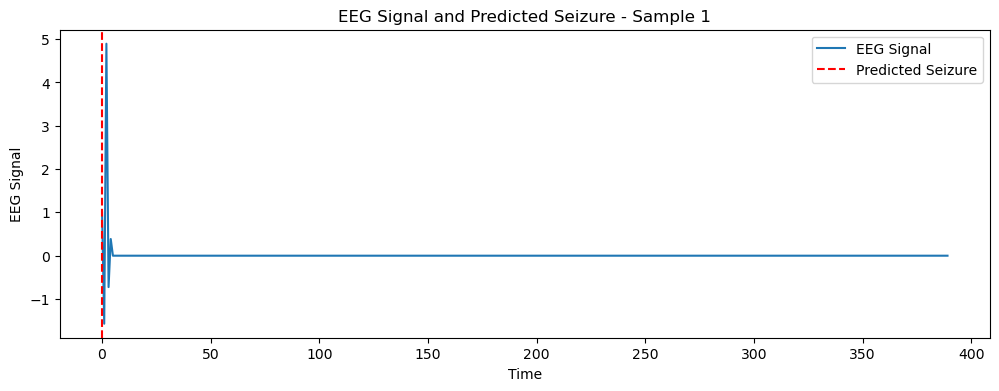

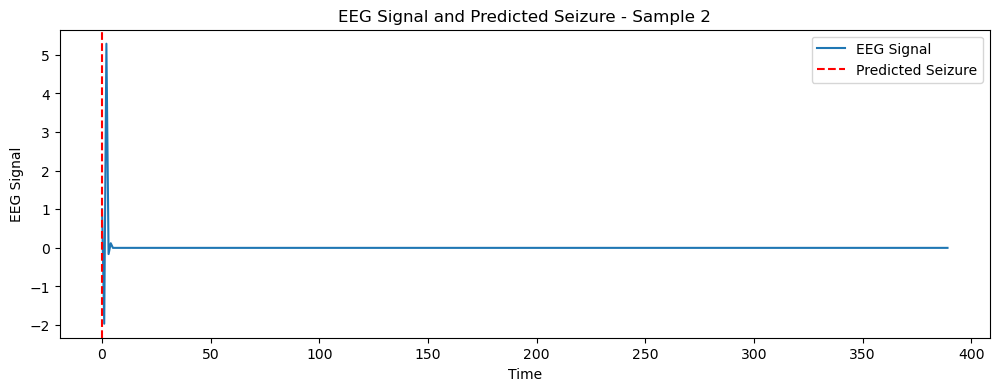

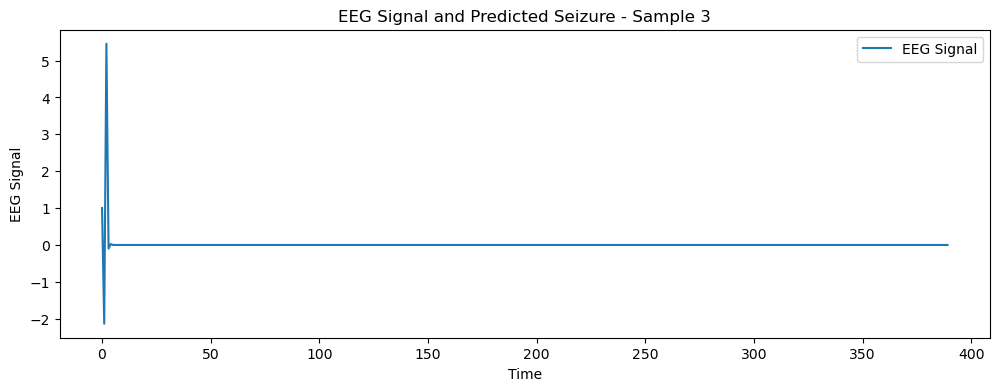

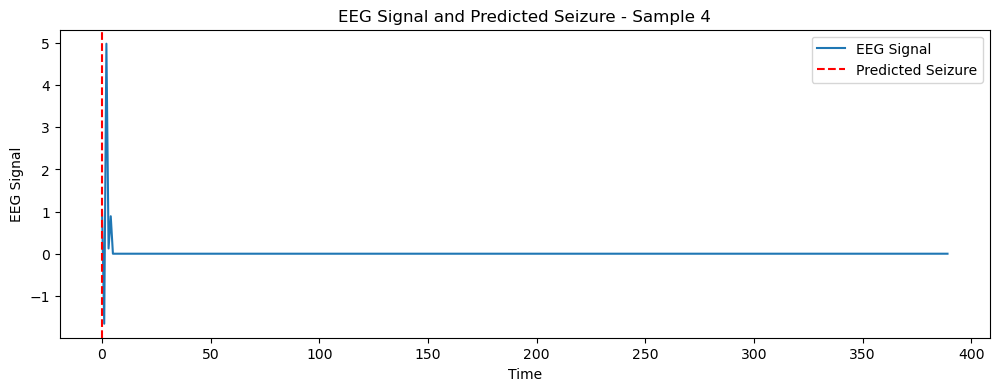

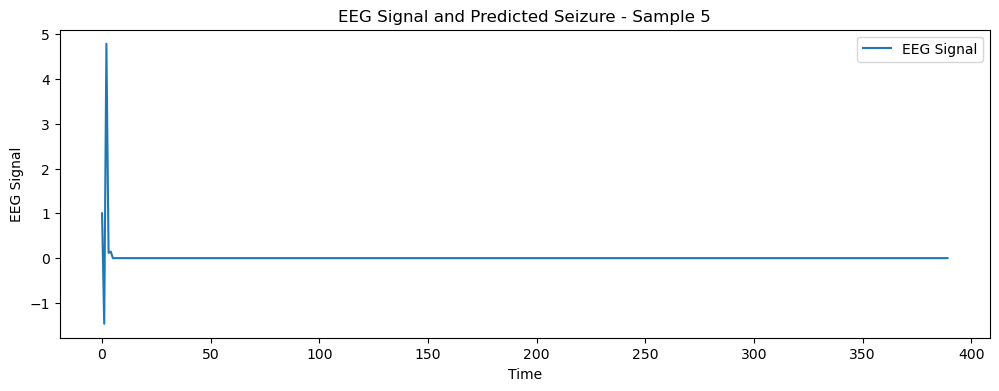

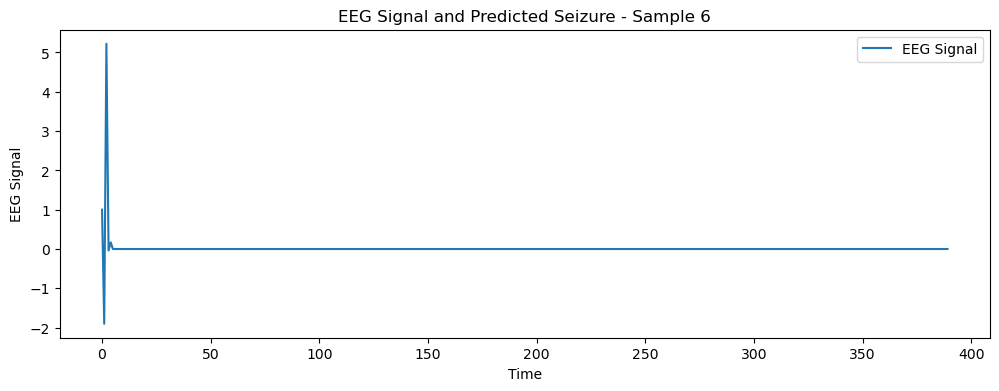

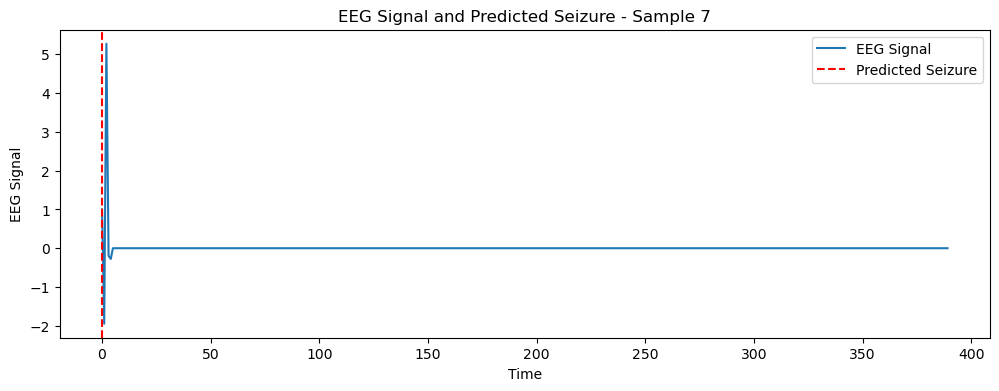

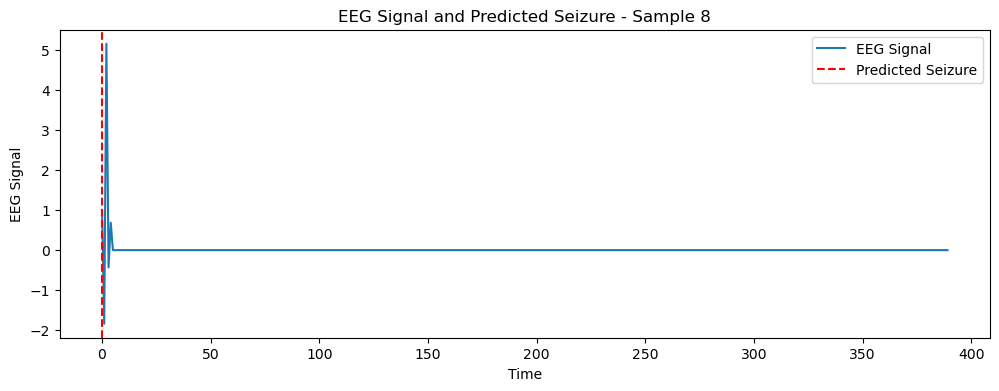

In [5]:
import matplotlib.pyplot as plt


test_samples = X[:8]
predictions = y_pred

# Plot EEG signals and predicted seizure periods
for i, sample in enumerate(test_samples):
    timestamp = sample[0]  
    eeg_signal = sample[1:] 

    plt.figure(figsize=(12, 4))
    plt.plot(timestamp + np.arange(len(eeg_signal)), eeg_signal, label='EEG Signal')

    # Highlight predicted seizure periods
    seizure_indices = np.where(predictions[i] == 1)[0]
    for idx in seizure_indices:
        plt.axvline(x=timestamp + idx, color='red', linestyle='--', label='Predicted Seizure')

    plt.title(f'EEG Signal and Predicted Seizure - Sample {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('EEG Signal')
    plt.legend()
    plt.show()

Confusion matrix, without normalization


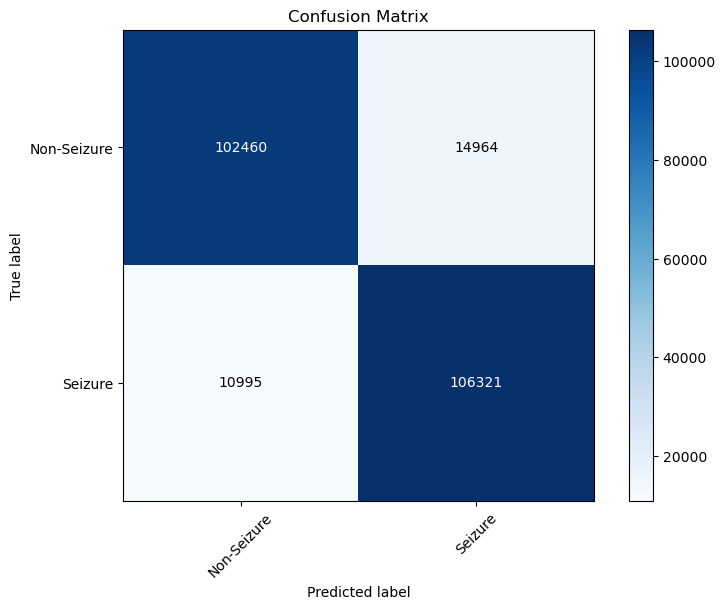

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix_custom(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title if title else 'Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix_custom(y_test, y_pred, classes=['Non-Seizure', 'Seizure'], normalize=False, title='Confusion Matrix')

### CNN Model

In [10]:
# CNN model

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))  
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


input_shape = (X_train.shape[1], 1) 
model = create_cnn_model(input_shape)
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred_val = np.round(y_pred_proba).astype(int)

# Calculate accuracy and F1 score
cnn_accuracy = accuracy_score(y_test, y_pred_val)
cnn_f1 = f1_score(y_test, y_pred_val)

print("CNN Model:")
print("Accuracy:", cnn_accuracy)
print(f"F1 Score: {cnn_f1}")

Epoch 1/5
8559/8559 [==============================] - 174s 20ms/step - loss: 0.6448 - accuracy: 0.6182 - val_loss: 0.6407 - val_accuracy: 0.6232
Epoch 2/5
8559/8559 [==============================] - 164s 19ms/step - loss: 0.6366 - accuracy: 0.6273 - val_loss: 0.6341 - val_accuracy: 0.6276
Epoch 3/5
8559/8559 [==============================] - 166s 19ms/step - loss: 0.6338 - accuracy: 0.6289 - val_loss: 0.6326 - val_accuracy: 0.6298
Epoch 4/5
8559/8559 [==============================] - 167s 19ms/step - loss: 0.6315 - accuracy: 0.6307 - val_loss: 0.6319 - val_accuracy: 0.6306
Epoch 5/5
7336/7336 [==============================] - 22s 3ms/step
CNN Model:
Accuracy: 0.6314305188719435
F1 Score: 0.6391023234472115


Visualization for CNN model

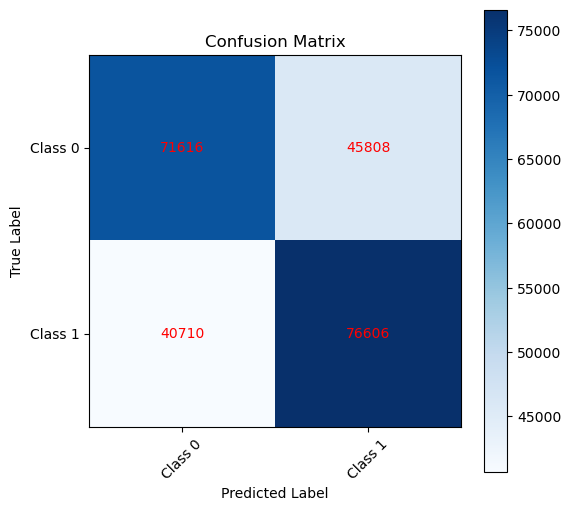

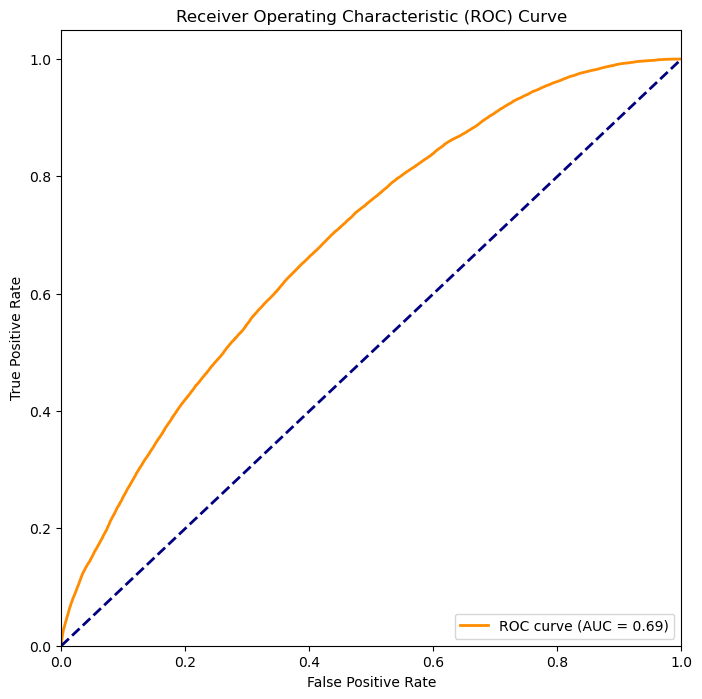

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_val)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adding the numbers on the heatmap
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')

plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Comparing Decision tree and CNN models

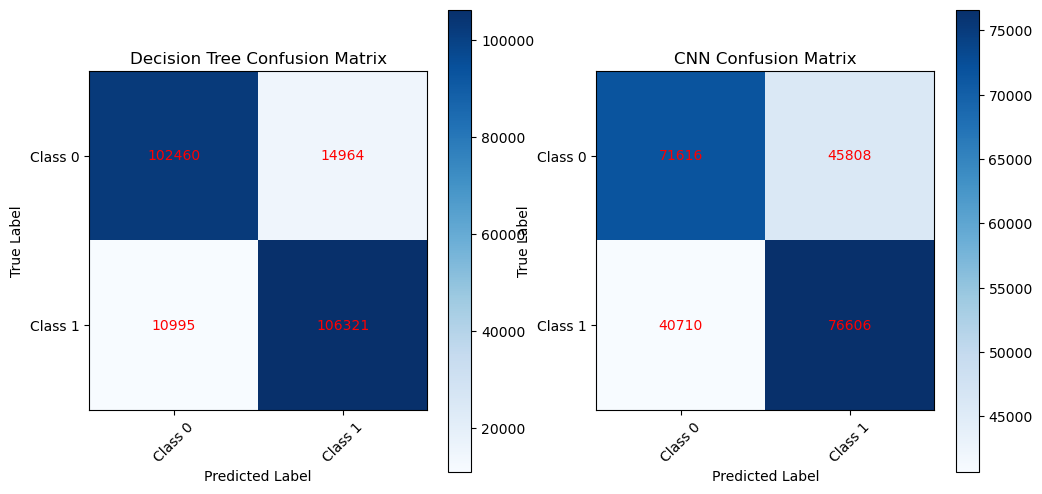

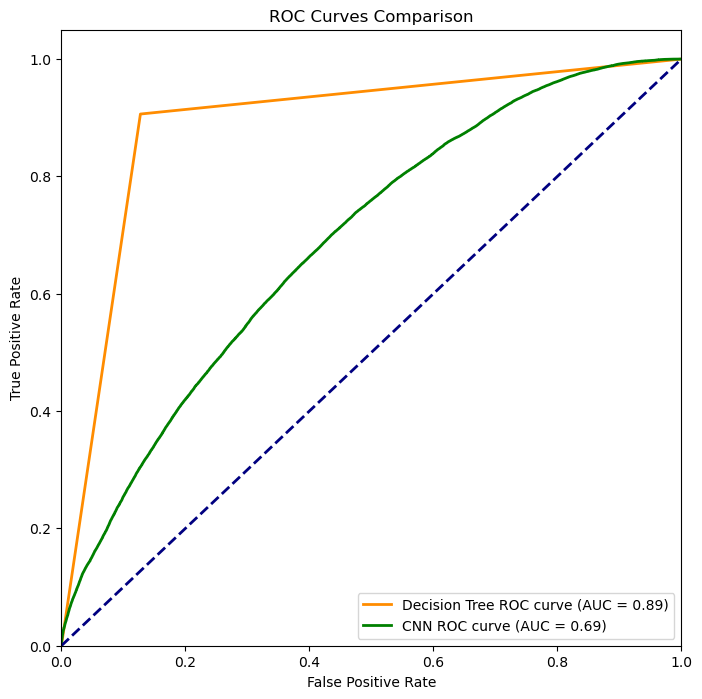

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Predictions for Decision Tree
y_pred_dt = clf.predict(X_test)
y_pred_proba_dt = clf.predict_proba(X_test)[:, 1]
# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)


# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred_val)
# ROC Curve for CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_proba)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


# Plotting Confusion Matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cm_dt, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.colorbar()
classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adding the numbers on the heatmap
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm_dt[i, j]), ha='center', va='center', color='red')

plt.subplot(1, 2, 2)
plt.imshow(cm_cnn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix')
plt.colorbar()
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adding the numbers on the heatmap
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm_cnn[i, j]), ha='center', va='center', color='red')

plt.show()

# Plotting ROC Curves
plt.figure(figsize=(8, 8))

plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'Decision Tree ROC curve (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_cnn, tpr_cnn, color='green', lw=2, label=f'CNN ROC curve (AUC = {roc_auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()
